<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/LO_FIFA22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![flag](https://upload.wikimedia.org/wikipedia/commons/7/71/Soccer_Sweden.png?20171226211103)

# Using linear optimization in R to pick the Swedish national football team

Many have seen the movie *Moneyball* starring Brad Pitt as Billy Beane. Beane was the GM of Oakland Athletics (baseball) and had great sucess using a datadriven approach when deciding which players to recruit and play. You can read more about Billy Beane on [Wikipedia](https://en.wikipedia.org/wiki/Billy_Beane)

In this project I will try something that's somewhat analogous to the Moneyball approach. Using linear optimization in R and data from FIFA22 (the videogame by EA Sports, [link](https://www.ea.com/sv-se/games/fifa/fifa-22)) I will try to find the best possible starting-11 for the Swedish mens national team.

In december 2021 Sweden ranked 18th in the world according to FIFA (the corrupt international football federation, not the videogame). Unfortunately Sweden just recently failed to qualify for the WC after loosing to Poland in the final playoff game for the WC.

Football is a complex sport. Games are more dynamic than for example games in baseball and flows back and forth rather than resetting, and repeating, the same procedure (such as pitching-batting). It's therefore harder to quantify player productivity and the dataset used for this project is of course not a *true* representation of skill (or productivity) in that sense.

But we'll just accept that and move on, shall we?

**The aim of the project is:**

* To pick the best possible starting 11 for the Swedish mens national team, and
* Find the optimal substitutions to make during the game under two different scenarios:
  * Team is loosing and need to win (go offense!)
  * Team is winning and need to defend the lead (go defense!)

* Subject to **constraints** (for example there needs to be a goalkeeper on the pitch at all times)

**Packages used for this project:**

* `tidyverse`
* `lpSolve` 

# Data
The data used for this project comes from Kaggle although I've downloaded it to my GitHub respository. You can read more about the data [here](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset).

In the following code chunk I'll:
* Download the data from my GitHub respository
* Prepare the data for analysis by:
  * Filtering out Swedish players only (this is of course also a constraint in a sense)
  * Removing unecessary variables, keeping:
    * `short_name` = The players name (in the format "Z. Ibrahimovic")
    * `age` = Age in years
    * `player_positions` = Positions (for example Striker, ST) the player can play in
    * `overall` = The overall skill of the player (this is what we'll try to maximize)
    * `preferred_foot` = The preferred foot (left/right) of the player
    * `defending` = The defensive skill of the player
    * `shooting` = The shooting ability ("finishing") of the player
  * Printing out the first 11 players of the new dataframe


In [51]:
library(tidyverse)

df_all_vars = read.csv(file = "https://github.com/karl-karlsson/data/raw/main/players_22.csv") # Download data

df = df_all_vars %>% 
filter(nationality_name=="Sweden") %>%  # Filter Swedish players
select(short_name, age, player_positions, overall, preferred_foot, defending, shooting) # Select relevant variables

print("First 11 rows")
df %>% head(n=11) 



[1] "First 11 rows"


,short_name,age,player_positions,overall,preferred_foot,defending,shooting
,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>
1,Z. Ibrahimović,39,ST,84,Right,34,87
2,A. Isak,21,ST,82,Right,29,82
3,E. Forsberg,29,"CAM, CF",81,Right,35,73
4,D. Kulusevski,21,"RW, CF",81,Left,56,74
5,V. Lindelöf,26,CB,80,Right,81,51
6,J. Larsson,24,ST,77,Left,29,78
7,A. Ekdal,31,"CM, CDM",76,Right,70,65
8,V. Claesson,29,"CAM, LM, CM",76,Right,48,76
9,R. Olsen,31,GK,76,Right,NA,NA


There are some things we can notice:
* There is no `attacking` attribute equivalent to the `defending` attribute
* Goalkeepers (GK) have missing values in the defending column
* Some players have multiple positions for example Victor Claesson can play centre-attacking-midfielder (CAM), left midfielder (LM) and center midfielder (CM) 

In the following steps we´ll try to make sense of the positions. We´ll also fix the `NA` values for the GK.


From the current `player_positions` variable. The aim is to create four new variables:
* `GK` = 1 if player can play goalkeeper, 0 otherwise
* `D`  = 1 if player can play defender, 0 otherwise
* `M` = 1 if player can play midfielder, 0 otherwise
* `A` = 1 if player can play attacker, 0 otherwise

We will have to deal with the fact that many players can play in multiple positions. What we whant to do is:
* Find all unique positions separated by "," in `player_positions` (we will use `separate_rows` from the `tidyr` package for that)
* Match the different positions (for example `CAM`) for each player to our schema above

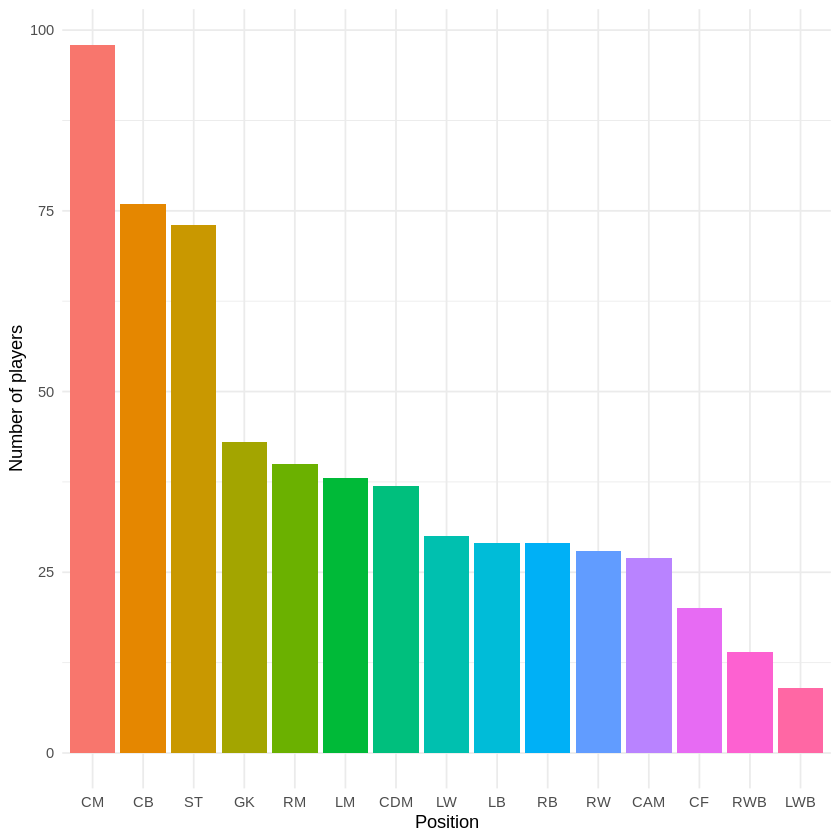

In [52]:
df %>% 
   separate_rows(player_positions) %>%
   group_by(player_positions) %>%
   summarise(n=n()) %>%
     mutate(pos = fct_reorder(player_positions, desc(n))) %>%
   ggplot(aes(x=pos, y=n, fill=pos))+
   geom_col()+
   theme_minimal()+
   theme(legend.position="none")+
   ylab("Number of players")+
   xlab("Position")

The figure above shows that there is 15 unique positions that a player can play. Centre midfielder (`CM`) is the position most players can play and left wing-back (`LWB`) is the position that fewest players can play.

The image below shows all positions on the pitch and their notations.

![positions](https://fifauteam.com/images/fifa21/positions/positionsmap.jpg)

From this we can create our new variables.

In [53]:
df = df %>%
# Goalkeepers
mutate(GK=ifelse(str_detect(player_positions,"GK"),1,0)) %>%
# Defenders
mutate(D=ifelse(str_detect(player_positions,"LWB|LB|CB|RB|RWB"),1,0)) %>%
# Midfielders 
mutate(M=ifelse(str_detect(player_positions,"LW\\b|LM|CM|CAM|CDM|RM|RW\\b"),1,0)) %>% # The "\\b":s (word-boundaries) are needed to not confuse LW with LWB and RW with RWB
# Attackers
mutate(A=ifelse(str_detect(player_positions,"LF|ST|CF|RF"),1,0))

df %>% 
head(n=11) %>%
arrange(-GK,-D,-M,-A)



short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,NA,NA,1,0,0,0
L. Augustinsson,27,"LB, LM",76,Left,72,60,0,1,1,0
V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
E. Forsberg,29,"CAM, CF",81,Right,35,73,0,0,1,1
D. Kulusevski,21,"RW, CF",81,Left,56,74,0,0,1,1
D. Moberg Karlsson,27,"RM, CF",76,Left,30,71,0,0,1,1
A. Ekdal,31,"CM, CDM",76,Right,70,65,0,0,1,0
V. Claesson,29,"CAM, LM, CM",76,Right,48,76,0,0,1,0
Z. Ibrahimović,39,ST,84,Right,34,87,0,0,0,1


Now we'll only fix the `NA` values for goalkeepers before we´ll start defining the objective function and constraints. We'll just replace all `NA` for goalkeepers with their `overall` rating instead.

In [54]:
df = df %>%
mutate(defending=coalesce(defending,overall),
       shooting=coalesce(shooting,overall)) 

df %>% head(n=11)

,short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Z. Ibrahimović,39,ST,84,Right,34,87,0,0,0,1
2,A. Isak,21,ST,82,Right,29,82,0,0,0,1
3,E. Forsberg,29,"CAM, CF",81,Right,35,73,0,0,1,1
4,D. Kulusevski,21,"RW, CF",81,Left,56,74,0,0,1,1
5,V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
6,J. Larsson,24,ST,77,Left,29,78,0,0,0,1
7,A. Ekdal,31,"CM, CDM",76,Right,70,65,0,0,1,0
8,V. Claesson,29,"CAM, LM, CM",76,Right,48,76,0,0,1,0
9,R. Olsen,31,GK,76,Right,76,76,1,0,0,0


# Objective function and constraints

The goal of this project is to pick the best starting 11.

The best 11 is defined as the 11 players that maximizes team `overall` rating (defined as the sum of players individual ratings).

Under no constraints we could just pick the 11 players with the highest overall attributes. Actually, we could just pick Zlatan 11 times. But we can't do that. We can only pick Zlatan once. And we can´t pick a half (0.5) Zlatan or a quarter (0.25) Zlatan etiher.

***Constraint 1:*** *All picks have to be binary (0,1)* <br><br>

We also have to pick 11 players. We can't pick 10 or 12.

***Constraint 2:*** *The sum of all picks need to sum to 11.*<br><br>

We also want a goalkeeper. But not more than one.

***Constraint 3:*** *There needs to be exactly one (==1) GK*<br><br>

We also want to play with some reasonable formation. We don't want to play only attackers (0-0-11) for example. Or 11 defenders (11-0-0). 

We'll say that we want a minimum of 3 defenders, a minimum of 3 midfielders and at least 1 attacker. This gives the following constraints.

***Constraint 4:*** *The # of defenders needs to be >= 3*

***Constraint 5:*** *The # of midfielders needs to be >= 3*

***Constraint 6:*** *The # of attackers needs to be >= 1*<br><br>

The next step is to program the objective function and constraints into the `lp` function of the `lpSolve` package ([link](https://cran.r-project.org/web/packages/lpSolve/lpSolve.pdf) to documentation)


In [55]:
install.packages("lpSolve")

library(lpSolve)

# To solve an optimization problem we need to pass the following arguments to the lp() function:

# direction (maximization or minimization?)
# objective.in (coefficients of the obj. function)
# const.mat (a matrix with constraints, 1 row per constraint)
# const.dir (the direction of each constraint, for example >= or <=)
# const.rhs (the value on the right hand side of the constraint)

# Set direction to "max" since we want to maximize objective function (ie. maximize overall player rating)
direction = "max"

# Numeric vector of coefficients of objective function (ie. the vector of player ratings)
objective.in = df[,4]

# Define constraints (we can define the first constraint (the binary constraint) by setting all.bin=TRUE later)

# Seceond constraint (sum of picks == 11)
c2 = replicate(nrow(df),1) # Create a vector with coefficient = 1 for all players
const.dir =c("==") # The direction of the constraint as a character vector
const.rhs =c(11) # Vector of numeric values for the right hand side of the constraint (here 11)

# Third constraint (exactly one GK)
c3 = df[,8] # Create a vector with coefficient = 1 for all GKs
const.dir[2] = "=="
const.rhs[2] = 1

# Fourth constraint (at least 3 defenders)
c4 = df[,9] # Create a vector with coefficient = 1 for all defenders
const.dir[3]=">=" # >= 3 defenders
const.rhs[3] = 3

# Fifth constraint (at least 3 midfielders)
c5 = df[,10] # Create a vector with coefficient = 1 for all midfielders
const.dir[4] = ">=" # >= 3 midfielders
const.rhs[4] = 3

# Sixth constraint (at least 1 attackers)
c6 = df[,11] # Create a vector with coefficient = 1 for all attackers
const.dir[5] = ">=" # >= 1 attackers
const.rhs[5] = 1

# Create a matrix of numeric constraint coefficients, one row per constraint, one column per variable
const.mat = rbind(c2,c3,c4,c5,c6)

print("Dimensions of constraint matrix (rows / cols)")
print(dim(const.mat))

# Plug it into the solver
solution = lp(direction=direction, objective.in=objective.in, const.mat=const.mat, const.dir=const.dir, const.rhs=const.rhs, all.bin=TRUE)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] "Dimensions of constraint matrix (rows / cols)"
[1]   5 385


# Solution to the first optimization problem (starting 11)

Lets print out the optimal solution to the first optimization problem (who should start?)

In [56]:
selected11 = solution$solution # The solution is a vector of binary variables with 1's corresponding to selected players row numbers

df[as.logical(selected11),] %>%
arrange(-GK,-D,-M,-A, preferred_foot)




short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,76,76,1,0,0,0
L. Augustinsson,27,"LB, LM",76,Left,72,60,0,1,1,0
V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
P. Jansson,30,CB,75,Right,75,42,0,1,0,0
D. Kulusevski,21,"RW, CF",81,Left,56,74,0,0,1,1
D. Moberg Karlsson,27,"RM, CF",76,Left,30,71,0,0,1,1
E. Forsberg,29,"CAM, CF",81,Right,35,73,0,0,1,1
V. Claesson,29,"CAM, LM, CM",76,Right,48,76,0,0,1,0
J. Larsson,24,ST,77,Left,29,78,0,0,0,1


The optimal solution is to play the 11 listed above.
Unfortunately Pontus Jansson has retired from the national team as of august 2021. We'll therefore remove him and rerun the optimization.

In [57]:
# Find Pontus Jansson row number
pontus_row = which(df$short_name=="P. Jansson")

# Remove him from dataframe, objective function and constraint matrix
df = df[-c(pontus_row),]
objective.in = objective.in[-c(pontus_row)]
const.mat = const.mat[,-c(pontus_row)] 

In [58]:
# Rerun the solver and print out the results
solution = lp(direction=direction, objective.in=objective.in, const.mat=const.mat, const.dir=const.dir, const.rhs=const.rhs, all.bin=TRUE)

selected11 = solution$solution

df[as.logical(selected11),] %>%
arrange(-GK,-D,-M,-A, preferred_foot)

summary1 = df[as.logical(selected11),] %>%
summarise(`Overall (mean)`=round(mean(overall),2),
`Defending (mean)`=round(mean(defending,2)),
`Shooting (mean)`=round(mean(shooting,2)))

summary1

short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,76,76,1,0,0,0
L. Augustinsson,27,"LB, LM",76,Left,72,60,0,1,1,0
F. Helander,28,CB,74,Left,75,33,0,1,0,0
V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
D. Kulusevski,21,"RW, CF",81,Left,56,74,0,0,1,1
D. Moberg Karlsson,27,"RM, CF",76,Left,30,71,0,0,1,1
E. Forsberg,29,"CAM, CF",81,Right,35,73,0,0,1,1
V. Claesson,29,"CAM, LM, CM",76,Right,48,76,0,0,1,0
J. Larsson,24,ST,77,Left,29,78,0,0,0,1


Overall (mean),Defending (mean),Shooting (mean)
<dbl>,<dbl>,<dbl>
78.45,48,74


Based on the output Filip Helander should play instead of Pontus Jansson.

Since some players can play in multiple positions the solver doesn't give the exact formation. But one possible formation would be the following 3-4-3 formation:

**GK:** R. Olsen

**Defenders:** L. Augustinsson, F. Helander, V. Lindelöf

**Midfielders:** D. Kulusevski, V. Claesson, E. Forsberg, D. Moberg Karlsson

**Attackers:** J. Larsson, Z. Ibrahimovic, A. Isak

My guess is that most people interested in football, and with some knowledge about the Swedish national team, would say that this starting 11 is a bit more offensive than typical pick by Swedish coach Janne Andersson.




# Solving the second problem (we're losing and need to score!)

Let's say that we (Sweden) are losing and need to **DO SOMETHING** to change the result. Using substitutions is one way to change the game.

Since the start of the corona pandeminc five substitutions have been allowed in matches organized by the European Football Ass. (UEFA).

That means that we can take five players off and replace them with five new players. 

The question is which substituions should we make?

Since we're losing we will change our objective function (that is to be maximized) to `shooting` instead of `overall` to make sure we can take advantage of any goal scoring opportunity.

We will also add another constraint that says we can only make five (5) substitutions.

With just a few lines of code we can change the neccesary inputs to the solver and find a new optimal solution.



In [59]:
# Change the objective function
objective.in = df[,7]

# Add another constraint that says that from the starting 11 at least 6 players need to remain on the pitch after all subs. are made
# That's the same as saying we can change 5 players since 11-6 = 5

# const.mat = rbind(const.mat, selected11) # Add the starting 11 (all starting players =1, all others= 0) to the const.mat matrix

const.rhs[6] = 6  
const.dir[6] = ">="

In [60]:
# Rerun the solver and print out the results
solution = lp(direction=direction, objective.in=objective.in, const.mat=const.mat, const.dir=const.dir, const.rhs=const.rhs, all.bin=TRUE)

after_offensive_subs = solution$solution

df[as.logical(after_offensive_subs),] %>%
arrange(-GK,-D,-M,-A, preferred_foot)

summary2 = df[as.logical(after_offensive_subs),] %>%
summarise(`Overall (mean)`=round(mean(overall),2),
`Defending (mean)`=round(mean(defending,2)),
`Shooting (mean)`=round(mean(shooting,2)))

summary2

Warning message in rbind(const.mat, const.dir.num, const.rhs):
“number of columns of result is not a multiple of vector length (arg 2)”


short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,76,76,1,0,0,0
K. Sema,27,"LW, LM, LWB",73,Left,60,66,0,1,1,0
G. Gudmundsson,22,"LB, LM",73,Left,66,64,0,1,1,0
E. Salomonsson,32,RB,70,Right,63,67,0,1,0,0
R. Quaison,27,"ST, LM, CAM",74,Right,44,75,0,0,1,1
O. Toivonen,34,"CAM, ST",73,Right,41,77,0,0,1,1
V. Claesson,29,"CAM, LM, CM",76,Right,48,76,0,0,1,0
J. Larsson,24,ST,77,Left,29,78,0,0,0,1
Z. Ibrahimović,39,ST,84,Right,34,87,0,0,0,1


Overall (mean),Defending (mean),Shooting (mean)
<dbl>,<dbl>,<dbl>
75.55,44,76


Whoa! That's an offensive lineup.
How it could look?

**GK:** R.Olsen

**Defenders:** K.Sema, G. Gudmundsson, E. Salomonsson

**Midfielders:** R. Quaison, O. Toivonen, V. Claesson

**Attackers:** J. Larsson, J. Guidetti, Z. Ibrahimovic, A. Isak

Unfortunately some players get to play on the wrong flank but they'll just have to manage (or we could write another constraint for this of course but we'll skip that for now).


# Solving the third problem (we're winning and want to secure the lead)

*Parking the bus* is an expression sometimes used in football. It refers to teams playing ultra-defensively with many players behind the ball, literally parking the team bus outside of their own penalty area.

Let's say we are winning and want to *park the bus*. Who should play?

The scenario is that we have the same 11 players on the pitch as those we started with.

We'll just have to change the objective function to maximize `defending` instead of `attacking`


In [61]:
# Assign the defensive column to the objective function
objective.in = df[,6]

# Rerun the solver and print out the results
solution = lp(direction=direction, objective.in=objective.in, const.mat=const.mat, const.dir=const.dir, const.rhs=const.rhs, all.bin=TRUE)

after_defensive_subs = solution$solution

df[as.logical(after_defensive_subs),] %>%
arrange(-GK,-D,-M,-A, preferred_foot)

summary3 = df[as.logical(after_defensive_subs),] %>%
summarise(`Overall (mean)`=round(mean(overall),2),
`Defending (mean)`=round(mean(defending,2)),
`Shooting (mean)`=round(mean(shooting,2)))

summary3

Warning message in rbind(const.mat, const.dir.num, const.rhs):
“number of columns of result is not a multiple of vector length (arg 2)”


short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,76,76,1,0,0,0
L. Augustinsson,27,"LB, LM",76,Left,72,60,0,1,1,0
F. Helander,28,CB,74,Left,75,33,0,1,0,0
J. Nilsson,27,CB,73,Left,74,32,0,1,0,0
R. Gagliolo,31,"LB, CB",73,Left,72,51,0,1,0,0
V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
M. Danielson,32,CB,73,Right,76,28,0,1,0,0
S. Holmén,29,CB,72,Right,74,36,0,1,0,0
M. Lustig,34,RB,71,Right,73,54,0,1,0,0


Overall (mean),Defending (mean),Shooting (mean)
<dbl>,<dbl>,<dbl>
75,74,51


This solution gives a very defensive lineup (7-2-1) that is perhaps a bit to unconventional. The reason is that some players (L. Augustinsson and D. Kulusevski) can play in multiple positions. They therefore satisfy multiple constraints but they can still only play in one position.

Therefore we'll add another constraint that says that says that there must be at least 5 midfielders OR attackers on the pitch.

In [62]:
midfielder_or_attacker = c() # Creates an emtpy vector

# Loop that checks if a player can play any of midfield or attacker
for(row in 1:nrow(df)) {
  midfielder_or_attacker[row] = max(df[row,10],df[row,11])
}

# Add constraint
const.mat = rbind(const.mat, midfielder_or_attacker)
const.dir[6] = ">="
const.rhs[6] = 5

# Solve again
solution = lp(direction=direction, objective.in=objective.in, const.mat=const.mat, const.dir=const.dir, const.rhs=const.rhs, all.bin=TRUE)

after_defensive_subs = solution$solution

df[as.logical(after_defensive_subs),] %>%
arrange(-GK,-D,-M,-A, preferred_foot)

short_name,age,player_positions,overall,preferred_foot,defending,shooting,GK,D,M,A
<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
R. Olsen,31,GK,76,Right,76,76,1,0,0,0
L. Augustinsson,27,"LB, LM",76,Left,72,60,0,1,1,0
G. Svensson,34,"CDM, CB, CM",72,Right,69,45,0,1,1,0
F. Helander,28,CB,74,Left,75,33,0,1,0,0
J. Nilsson,27,CB,73,Left,74,32,0,1,0,0
V. Lindelöf,26,CB,80,Right,81,51,0,1,0,0
M. Danielson,32,CB,73,Right,76,28,0,1,0,0
S. Holmén,29,CB,72,Right,74,36,0,1,0,0
D. Kulusevski,21,"RW, CF",81,Left,56,74,0,0,1,1


This is at least a little more realistic it would be possible to play something like:

**GK:** R. Olsen

**Defenders:** J. Nilsson-F. Helander-V. Lindelöf-S. Holmén-M. Danielsson

**Midfielders:** L. Augustinsson - A. Ekdal - O. Lewicki - G. Svensson

**Attacker:** D. Kulusevski

# Summary
In this project I used data from FIFA22 and linear optimization to pick the best possible starting 11 for the Swedish national team under some constraints. I also tried to find new optimal solutions based on how the game might evolve.

* **Problem 1:** Find the optimal starting 11 (maximize overall ability)
* **Problem 2:** Make optimal substitutions to maximize offensive capacity
* **Problem 3:** Make optimal substitutions to maximize defensive capacity 

Below is a summary of the mean `overall`,`defending` and `attacking` ratings for each problem.

Could linear optimization help in the real world? Perhaps, but there are of course issues. The most important ones are:

* **What's the true objective function?** Here I just assumed that maximizing the sum of overall ability (or shooting or defending) will put the best performing team on the pitch (given the circumstances) but football is of course more complex than that. For example, some players might collaborate realy well and support each others style of play. In microeconomic theory this would mean that their skills are complementary rather than substitutable.

* **Good quality data?** Here I just used data from the FIFA22 game but can skill be accurately measured in something as complex as football?

If these two issues could be adressed to a good degree then it could be a viable option. Especially for smaller clubs that, in contrast to national teams, also operate under budget constraints.

This was done mostly for my own learning experience. If you've read all the way here I hope you've found it useful, or interesting, for whatever reason.

In [63]:
summary = rbind(summary1,summary2,summary3) 
summary$Problem = 1:nrow(summary)
summary %>% relocate(Problem) %>% round()

Problem,Overall (mean),Defending (mean),Shooting (mean)
<dbl>,<dbl>,<dbl>,<dbl>
1,78,48,74
2,76,44,76
3,75,74,51


# Contact details

![bild](https://avatars.githubusercontent.com/u/99097833?v=4)

Feel free to reach out:

* Twitter: [@vaxjo_kalle](https://twitter.com/vaxjo_kalle) 
* LinkedIn: [My profile](https://www.linkedin.com/in/karlkarlssonvaxjo/)
* E-mail: [karl_karlsson@icloud.com](mailto:karl_karlsson@icloud.com)
* GitHub: [github.com/karl-karlsson](https://github.com/karl-karlsson)